<a href="https://colab.research.google.com/github/Abdulbarikassim/FaceEmotionDetection/blob/main/mobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_set = '/content/drive/MyDrive/datasets/ckextended.csv'

In [44]:
import pandas as pd

df = pd.read_csv(data_set)


# Inspect the first few pixel entries
print("Sample pixel data:", df['pixels'].head())

# Check the length of pixel data for each row
df['pixel_count'] = df['pixels'].apply(lambda x: len(x.split()))
print("Pixel counts:", df['pixel_count'].describe())
print("Rows with incorrect pixel count:", df[df['pixel_count'] != 2304])

Sample pixel data: 0    36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...
1    88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...
2    9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...
3    104 106 108 104 95 50 60 61 58 83 126 133 139 ...
4    68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...
Name: pixels, dtype: object
Pixel counts: count     920.0
mean     2304.0
std         0.0
min      2304.0
25%      2304.0
50%      2304.0
75%      2304.0
max      2304.0
Name: pixel_count, dtype: float64
Rows with incorrect pixel count: Empty DataFrame
Columns: [emotion, pixels, Usage, pixel_count]
Index: []


  ### Preprocessing the data.

In [45]:
import numpy as np
import cv2
import pandas as pd

def load_ck_plus_dataset_from_csv(csv_path):
    df = pd.read_csv(csv_path)

    images = []
    labels = []

    for idx, row in df.iterrows():
        # Convert pixel string to array
        pixel_values = np.fromstring(row['pixels'], dtype=int, sep=' ')

        # Validate pixel count
        if len(pixel_values) != 2304:
            print(f"Skipping row {idx}: Invalid pixel count ({len(pixel_values)})")
            continue

        # Check for invalid pixel values
        if np.any(pixel_values < 0) or np.any(pixel_values > 255):
            print(f"Skipping row {idx}: Pixel values out of range ({pixel_values.min()}, {pixel_values.max()})")
            continue

        # Reshape to 48x48x1 and cast to uint8
        img = pixel_values.reshape(48, 48, 1).astype(np.uint8)

        # Resize and preprocess
        try:
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = img / 255.0  # Normalize to [0,1]
            images.append(img)
            labels.append(row['emotion'])
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            continue

    return np.array(images), np.array(labels)

In [46]:

# Load the dataset
X, y = load_ck_plus_dataset_from_csv(data_set)

# Verify shapes and labels
print("Images shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique emotions:", np.unique(y))

Images shape: (920, 224, 224, 3)
Labels shape: (920,)
Unique emotions: [0 1 2 3 4 5 6 7]


## Training the model

In [48]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)


print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (736, 224, 224, 3) (736, 8)
Test shapes: (184, 224, 224, 3) (184, 8)


In [49]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Small
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical



# create  the MobileNetV3 model
def create_mobilenetv3_model(num_classes=8):
    base_model = MobileNetV3Small(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False,
        alpha=1.0
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile the model
model = create_mobilenetv3_model(num_classes=8)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [50]:
#let see the model summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,014,008 (3.87 MB)

 Trainable params: 74,888 (292.53 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [51]:
# Training parameters
batch_size = 32
epochs = 20

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Train the model
history = model.fit(
    data_augmentation(X_train), y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 504ms/step - accuracy: 0.5460 - loss: 1.5487 - val_accuracy: 0.6413 - val_loss: 1.3144
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 506ms/step - accuracy: 0.6651 - loss: 1.3479 - val_accuracy: 0.6413 - val_loss: 1.3161
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 506ms/step - accuracy: 0.6594 - loss: 1.3279 - val_accuracy: 0.6413 - val_loss: 1.3150
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 404ms/step - accuracy: 0.6501 - loss: 1.3296 - val_accuracy: 0.6413 - val_loss: 1.3137
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step - accuracy: 0.6426 - loss: 1.3890 - val_accuracy: 0.6413 - val_loss: 1.3137
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 427ms/step - accuracy: 0.6403 - loss: 1.3791 - val_accuracy: 0.6413 - val_loss: 1.3128
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - accuracy: 0.6728 - loss: 1.2952 - val_accuracy: 0.6413 - val_loss: 1.3204
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 355ms/step - accuracy: 0.6329 - loss: 1.3854 - val_accur

In [58]:
# Fine-tuning
# Unfreeze the base model
model.layers[0].trainable = True
fine_tune_at = len(model.layers[0].layers) // 2
for layer in model.layers[0].layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for 30 more epochs
fine_tune_epochs = 30
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    data_augmentation(X_train), y_train,
    batch_size=batch_size,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=(X_test, y_test)
)
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


Epoch 20/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 947ms/step - accuracy: 0.8343 - loss: 0.6196 - val_accuracy: 0.6413 - val_loss: 1.8612
Epoch 21/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 742ms/step - accuracy: 0.8627 - loss: 0.4478 - val_accuracy: 0.6413 - val_loss: 1.9016
Epoch 22/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 742ms/step - accuracy: 0.8888 - loss: 0.3619 - val_accuracy: 0.6413 - val_loss: 1.8606
Epoch 23/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 720ms/step - accuracy: 0.9048 - loss: 0.2786 - val_accuracy: 0.6413 - val_loss: 1.8112
Epoch 24/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 750ms/step - accuracy: 0.9215 - loss: 0.2485 - val_accuracy: 0.6413 - val_loss: 1.7449
Epoch 25/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 698ms/step - accuracy: 0.9101 - loss: 0.2575 - val_accuracy: 0.6413 - val_loss: 1.5939
Epoch 26/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 740ms/step - accuracy: 0.9380 - loss: 0.2048 - val_accuracy: 0.6413 - val_loss: 1.5767
Epoch 27/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 703ms/step - accuracy: 0.9190 - loss: 0.2340 - 

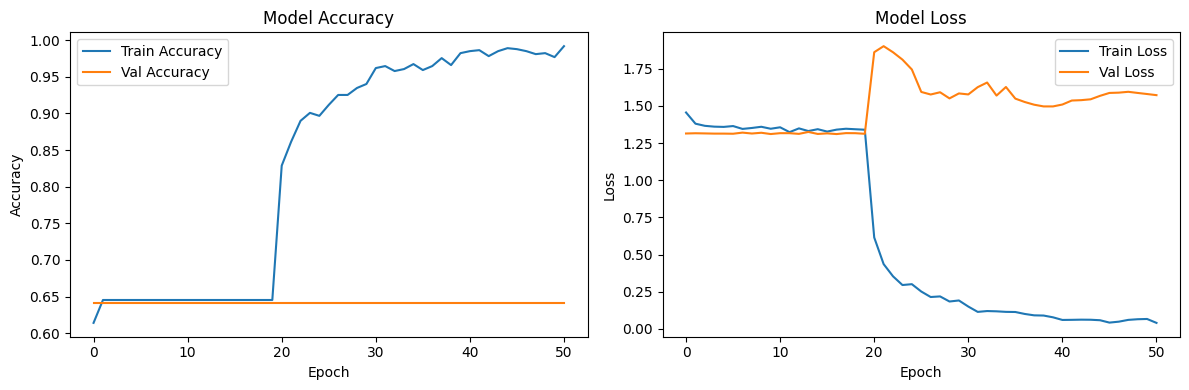

In [59]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
